In [1]:
import time

import numpy as np
import pandas as pd
import numba as nb

import matplotlib.pyplot as plt

from rectools import Columns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
interactions = pd.read_csv('../../PycharmProjects/RecSys_DEMO/Source/Kion/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])
interactions.head()

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


## Homework

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [3]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [4]:
top_k = 5
df, users, recs = generate_subsample(3, top_k) # выборка для теста
target = df.values

In [5]:
def mrr_naive(target, users, recs):
    user_rr_sum = 0 # здесь будем накапливать значения reciprocal_rank для каждого пользователя
    
    for i, user in enumerate(users):
        user_rr = 0 # обнуляем reciprocal_rank очередного пользователя для случая, если нет пересечений между
                    # списками предсказанных items и актуальными
        
        # находим первый индекс "угаданного" item и вычисляем reciprocal_rank для данного user
        for j in range(len(recs[i])):
            if recs[i][j] in target[target[:, 0] == user][:, 1] and user_rr == 0:
                user_rr = 1 / (j + 1)
        
        user_rr_sum += user_rr
    
    # возвращаем среднее значение reciprocal_rank по всем users
    return user_rr_sum / len(users)

In [6]:
mrr_naive(target, users, recs)

0.17777777777777778

In [7]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs):
    user_rr_sum = 0 # здесь будем накапливать значения reciprocal_rank для каждого пользователя
    
    for i in nb.prange(len(users)):
        user = users[i]
        user_rr = 0 # обнуляем reciprocal_rank очередного пользователя для случая, если нет пересечений между
                    # списками предсказанных items и актуальными
        
        # находим первый индекс "угаданного" item и вычисляем reciprocal_rank для данного user
        for j in nb.prange(len(recs[i])):
            if recs[i][j] in target[target[:, 0] == user][:, 1] and user_rr == 0:
                user_rr = 1 / (j + 1)
        
        user_rr_sum += user_rr
    
    # возвращаем среднее значение reciprocal_rank по всем users
    return user_rr_sum / len(users)

In [8]:
mrr_numba(target, users, recs)

0.17777777777777778

In [9]:
mrr_numba(target, users, recs)

0.17777777777777778

In [10]:
def mrr_pandas(df, users, recs):
    
    k = len(recs[0])
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1

    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    
    return (1 / df_recs.groupby(Columns.User)['rank'].min()).sum() / len(users)

In [11]:
mrr_pandas(df, users, recs)

0.17777777777777778

In [43]:
top_k_lst = [10, 50, 100]
users_count = [10**i for i in range(1,6)]

naive_dct = {}
numba_dct = {}
pandas_dct = {}

for k in top_k_lst:
    print('users_count: ', end='')
    for u_cnt in users_count:
        df, users, recs = generate_subsample(u_cnt, k)
        target = df.values
        
        print(f', {u_cnt}' if u_cnt != users_count[0] else u_cnt, end='')

        start_time = time.time()
        mrr_naive(target, users, recs) # замер времени работы naive-варианта MRR
        sec = time.time() - start_time
        naive_dct.setdefault(f'top_{k}', []).append(round(sec, 4))
        
        start_time = time.time()
        mrr_numba(target, users, recs) # замер времени работы numba-варианта MRR
        sec = time.time() - start_time
        numba_dct.setdefault(f'top_{k}', []).append(round(sec, 4))

        start_time = time.time()
        mrr_pandas(df, users, recs) # замер времени работы pandas-варианта MRR
        sec = time.time() - start_time
        pandas_dct.setdefault(f'top_{k}', []).append(round(sec, 4))
        
    print(f'\nnaive_dct - top_{k}:', naive_dct[f'top_{k}'])
    print(f'\nnumba_dct - top_{k}:', numba_dct[f'top_{k}'])
    print(f'\npandas_dct - top_{k}:', pandas_dct[f'top_{k}'])
    print('=' * 25)

users_count: 10, 100, 1000, 10000, 100000
naive_dct - top_10: [0.0005, 0.0058, 0.139, 9.512, 969.9879]

numba_dct - top_10: [0.0, 0.0002, 0.0108, 1.0957, 126.4712]

pandas_dct - top_10: [0.0035, 0.0036, 0.0054, 0.0213, 0.3294]
users_count: 10, 100, 1000, 10000, 100000
naive_dct - top_50: [0.0028, 0.0325, 0.83, 50.72, 4989.0994]

numba_dct - top_50: [0.0001, 0.0012, 0.0647, 5.31, 602.4801]

pandas_dct - top_50: [0.0036, 0.0043, 0.0115, 0.0687, 1.0965]
users_count: 10, 100, 1000, 10000, 100000
naive_dct - top_100: [0.0049, 0.0594, 1.266, 94.6697, 8924.374]

numba_dct - top_100: [0.0002, 0.0023, 0.0955, 11.042, 1091.2096]

pandas_dct - top_100: [0.0036, 0.0045, 0.0127, 0.1893, 2.183]


In [2]:
naive_dct = {
    'top_10': [0.0005, 0.0058, 0.139, 9.512, 969.9879],
    'top_50': [0.0028, 0.0325, 0.83, 50.72, 4989.0994],
    'top_100': [0.0049, 0.0594, 1.266, 94.6697, 8924.374],
}

numba_dct = {
    'top_10': [0.0, 0.0002, 0.0108, 1.0957, 126.4712],
    'top_50': [0.0001, 0.0012, 0.0647, 5.31, 602.4801],
    'top_100': [0.0002, 0.0023, 0.0955, 11.042, 1091.2096],
}

pandas_dct = {
    'top_10': [0.0035, 0.0036, 0.0054, 0.0213, 0.3294],
    'top_50': [0.0036, 0.0043, 0.0115, 0.0687, 1.0965],
    'top_100': [0.0036, 0.0045, 0.0127, 0.1893, 2.183],
}

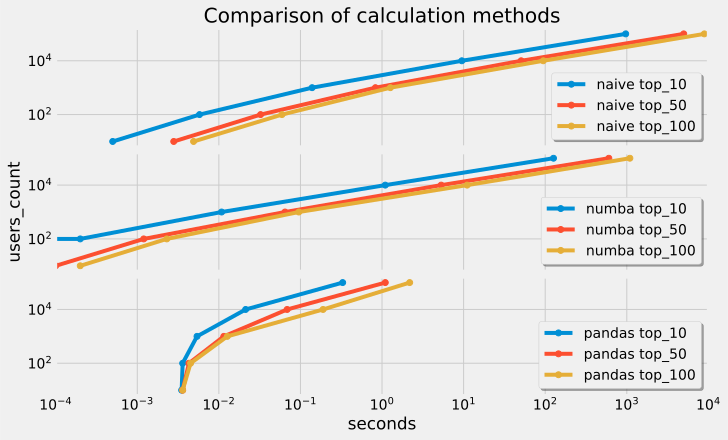

In [3]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6), layout='constrained')

for i in range(3):
    ax[i].set_xlim(1e-4, 1e4)
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")

for k in top_k_lst:
    ax[0].plot(naive_dct[f'top_{k}'], users_count, marker="o", label=f'naive top_{k}')
    ax[1].plot(numba_dct[f'top_{k}'], users_count, marker="o", label=f'numba top_{k}')
    ax[2].plot(pandas_dct[f'top_{k}'], users_count, marker="o", label=f'pandas top_{k}')

ax[2].set_xlabel('seconds')
ax[1].set_ylabel('users_count')
ax[0].set_title('Сomparison of calculation methods')
ax[0].legend(shadow=True, fancybox=True, loc='lower right')
ax[1].legend(shadow=True, fancybox=True, loc='lower right')
ax[2].legend(shadow=True, fancybox=True, loc='lower right')

plt.show()

#### Выводы:
Ориентируясь на логарифмическую шкалу осей видим, что numba в среднем на порядок работает быстрее, чем
naive-исполнение, но pandas-вариант хоть на начальном этапе незначительно уступает по времени исполнения двум другим вариантам вычислений метрики MRR, в то же время с увеличением объёма данных сильно ускоряет вычисления,
итоговый развыв два-три порядка.